In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
from lifelines import KaplanMeierFitter

In [3]:
df = pd.read_csv('relations_minified_versioning.csv')

print("Shape:", df.shape)

print("Columns:", df.columns.tolist())

# Info summary (non-null counts, data types)
print("Info:")
df.info()

# View the first 5 rows
print("Head:\n", df.head())

Shape: (1651064, 6)
Columns: ['dependency_id', 'interval_start_days', 'interval_end_days', 'requirement_type', 'is_out_of_date', 'is_exposed']
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651064 entries, 0 to 1651063
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   dependency_id        1651064 non-null  int64 
 1   interval_start_days  1651064 non-null  int64 
 2   interval_end_days    1651064 non-null  object
 3   requirement_type     1651064 non-null  object
 4   is_out_of_date       1651064 non-null  object
 5   is_exposed           1651064 non-null  object
dtypes: int64(2), object(4)
memory usage: 75.6+ MB
Head:
    dependency_id  interval_start_days interval_end_days  requirement_type  \
0            313                 2584              2734  floating - minor   
1         832528                  554               601  floating - minor   
2         832528                  258     

In [4]:
## Data Preprocessing
df['is_out_of_date'] = df['is_out_of_date'].map({'t': True, 'f': False})
df['is_exposed'] = df['is_exposed'].map({'t': True, 'f': False})

In [5]:
df['interval_start_days'] = pd.to_numeric(df['interval_start_days'], errors='coerce')
df = df.dropna(subset=['interval_start_days'])
df['interval_end_days'] = pd.to_numeric(df['interval_end_days'], errors='coerce') ##coerce the errors to drop /N (NA) value in data
df = df.dropna(subset=['interval_end_days'])

In [6]:
df.dtypes

dependency_id            int64
interval_start_days      int64
interval_end_days      float64
requirement_type        object
is_out_of_date            bool
is_exposed                bool
dtype: object

In [7]:
# 6 requirement types 
print(df['requirement_type'].unique())

['floating - minor' 'floating - major' 'pinned' 'other' 'floating - patch'
 'floating - major - restrictive']


In [8]:
# Need to convert the requirement_type column to a categorical type
df['requirement_type'] = pd.Categorical(
    df['requirement_type'],
    categories=[
        'floating - major', # This is the baseline category for one-hot encoding
        'floating - major - restrictive',
        'floating - minor',
        'floating - patch',
        'pinned',
        'other'
    ],
    ordered=True
)
df = pd.get_dummies(df, columns=['requirement_type'], drop_first=True)

In [9]:
# Sorting has effect on the model since the model expects the data for each individual together
df.sort_values(by=['dependency_id', 'interval_start_days', 'interval_end_days'], inplace=True)

df.head()

,dependency_id,interval_start_days,interval_end_days,is_out_of_date,is_exposed,requirement_type_floating - major - restrictive,requirement_type_floating - minor,requirement_type_floating - patch,requirement_type_pinned,requirement_type_other
617666,14,0,1.0,True,False,False,False,False,True,False
617667,14,1,2.0,True,False,False,False,False,True,False
617671,14,2,5.0,True,False,False,False,False,True,False
617669,14,5,5.0,True,False,False,False,False,True,False
617660,14,5,10.0,True,False,False,False,False,True,False


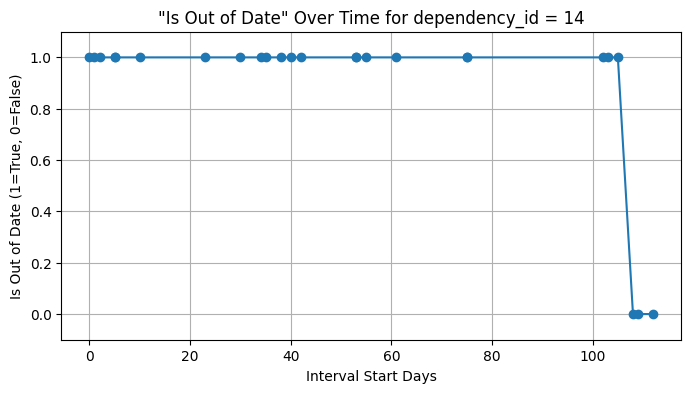

In [105]:
filtered_df = df[df['dependency_id'] == 14]
# Plotting
plt.figure(figsize=(8, 4))
plt.plot(filtered_df['interval_start_days'], filtered_df['is_out_of_date'].astype(int), marker='o')
plt.title('"Is Out of Date" Over Time for dependency_id = 14')
plt.xlabel('Interval Start Days')
plt.ylabel('Is Out of Date (1=True, 0=False)')
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.show()

In [10]:
# Looking at the transition states within the data

print("Unique dependencies:", df['dependency_id'].nunique())

# Sort the data by dependency_id and interval_end_days
df = df.sort_values(['dependency_id', 'interval_end_days'])

# Initialize a counter for unique dependencies with transitions
unique_transitions = set()

# Group by dependency_id
for dep_id, group in df.groupby('dependency_id'):
    # Check if this dependency has both False and True values
    if False in group['is_out_of_date'].values and True in group['is_out_of_date'].values:
        # Get the values as a list
        values = group['is_out_of_date'].tolist()
        
        # Check if there's at least one transition from False to True
        for i in range(len(values) - 1):
            if values[i] == False and values[i + 1] == True:
                unique_transitions.add(dep_id)
                break  # We only need to count this dependency once

print(f"Number of unique dependencies transitioning from is_out_of_date=False to True: {len(unique_transitions)}")

# Initialize a counter for unique dependencies with transitions
unique_transitions_2 = set()

# Group by dependency_id
for dep_id, group in df.groupby('dependency_id'):
    # Check if this dependency has both False and True values
    if True in group['is_out_of_date'].values and False in group['is_out_of_date'].values:
        # Get the values as a list
        values = group['is_out_of_date'].tolist()
        
        # Check if there's at least one transition from True to False
        for i in range(len(values) - 1):
            if values[i] == True and values[i + 1] == False:
                unique_transitions_2.add(dep_id)
                break  # We only need to count this dependency once

print(f"Number of unique dependencies transitioning from is_out_of_date=True to False: {len(unique_transitions_2)}")


# Initialize a counter for unique dependencies with transitions
unique_transitions_vuln = set()

# Group by dependency_id
for dep_id, group in df.groupby('dependency_id'):
    # Check if this dependency has both False and True values
    if False in group['is_exposed'].values and True in group['is_exposed'].values:
        # Get the values as a list
        values = group['is_exposed'].tolist()
        
        # Check if there's at least one transition from False to True
        for i in range(len(values) - 1):
            if values[i] == False and values[i + 1] == True:
                unique_transitions_vuln.add(dep_id)
                break  # We only need to count this dependency once

print(f"Number of unique dependencies transitioning from is_exposed=False to True: {len(unique_transitions_vuln)}")


# Initialize a counter for unique dependencies with transitions
unique_transitions_vuln_2 = set()

# Group by dependency_id
for dep_id, group in df.groupby('dependency_id'):
    # Check if this dependency has both False and True values
    if True in group['is_exposed'].values and False in group['is_exposed'].values:
        # Get the values as a list
        values = group['is_exposed'].tolist()
        
        # Check if there's at least one transition from True to False
        for i in range(len(values) - 1):
            if values[i] == True and values[i + 1] == False:
                unique_transitions_vuln_2.add(dep_id)
                break  # We only need to count this dependency once

print(f"Number of unique dependencies transitioning from is_exposed=True to False: {len(unique_transitions_vuln_2)}")


Unique dependencies: 17636
Number of unique dependencies transitioning from is_out_of_date=False to True: 8228
Number of unique dependencies transitioning from is_out_of_date=True to False: 7196
Number of unique dependencies transitioning from is_exposed=False to True: 263
Number of unique dependencies transitioning from is_exposed=True to False: 238


In [ ]:
## Using proportional_hazard_test to test the proportional hazards assumption
from lifelines.statistics import proportional_hazard_test

## removing the dependencies that have interval start_days = interval_end_days (time = 0)
df_model = df[df["interval_start_days"] != df["interval_end_days"]]

cph.fit(df_model, 'interval_end_days', 'is_out_of_date')
results = proportional_hazard_test(cph, df_model, time_transform="rank")
results.print_summary()

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1.28746e+06 total observations, 1.06777e+06 right-censored observations>
         test_name = proportional_hazard_test

---
                                                 test_statistic      p  -log2(p)
dependency_id                                            165.48 <0.005    123.39
interval_start_days                                    69059.01 <0.005       inf
is_exposed                                                15.01 <0.005     13.19
requirement_type_floating - major - restrictive          161.67 <0.005    120.63
requirement_type_floating - minor                        254.27 <0.005    187.74
requirement_type_floating - patch                         23.32 <0.005     19.47
requirement_type_other                                   257.48 <0.005    190.07
requirement_type_pinned                                  294.03 <0.005    216.53

Based on the output above, we see that the Proprortional Hazards assumption is violated